In [1]:
%cd /scratch/ejk5818/FLORIDA

/scratch/ejk5818/FLORIDA


In [2]:
from plot_utils import *

# mal pcnt experiment

<Axes: xlabel='mal_pcnt'>

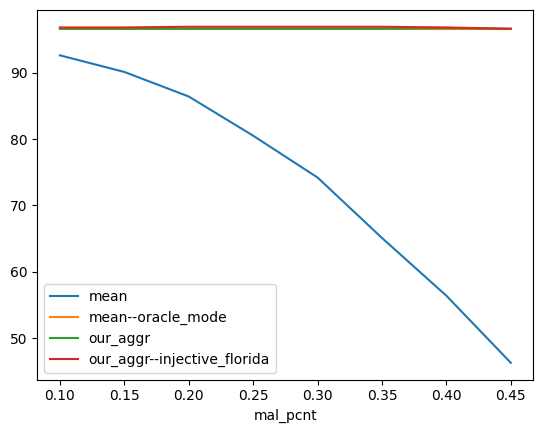

In [3]:
mal_pcnt_results = get_mal_pcnt_exp_results()
mal_pcnt_df = pd.DataFrame(mal_pcnt_results, index=mal_pcnt_results['mean'].keys(), columns=mal_pcnt_results.keys())
mal_pcnt_df.index.name = 'mal_pcnt'
mal_pcnt_df.plot()

# non-IID experiment

In [5]:
noniid_results = get_noniid_exp_results()

<Axes: >

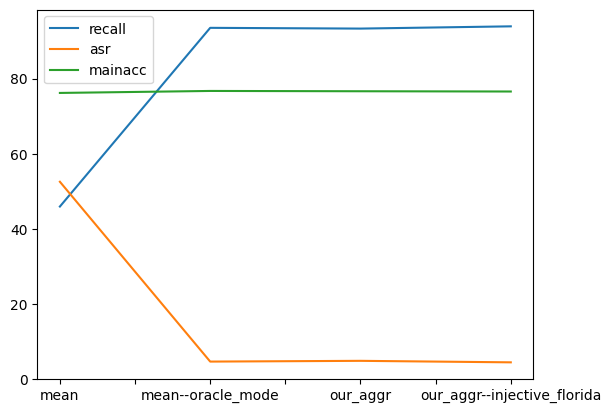

In [6]:
noniid_one_class_expert_df = pd.DataFrame(noniid_results['one_class_expert']).T
noniid_one_class_expert_df.plot()

<Axes: >

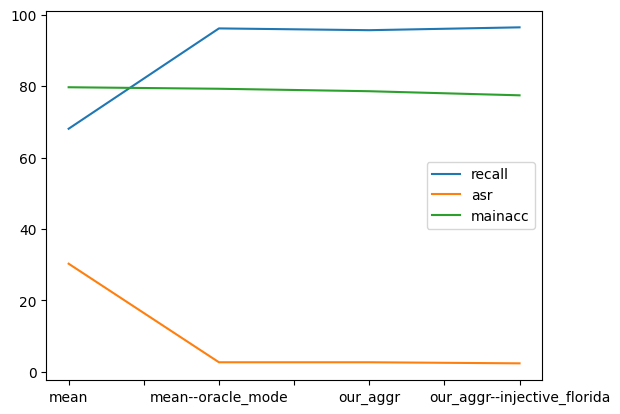

In [7]:
noniid_sampling_dirichlet_df = pd.DataFrame(noniid_results['sampling_dirichlet']).T
noniid_sampling_dirichlet_df.plot()

# mal val type experiment

In [3]:
final_result, avg_tpr, avg_tnr = get_mal_val_type_results()

In [7]:
cluster_final_result = final_result['our_aggr']
cluster_final_result_df = pd.DataFrame(cluster_final_result)
print(cluster_final_result_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 79.300000 & 79.100000 & 79.300000 \\
dba & 1.733333 & 2.466667 & 1.722222 \\
\bottomrule
\end{tabular}



In [8]:
bijective_final_result = final_result['our_aggr--injective_florida']
bijective_final_result_df = pd.DataFrame(bijective_final_result)
print(bijective_final_result_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 83.600000 & 83.400000 & 82.000000 \\
dba & 1.688889 & 1.866667 & 1.477778 \\
\bottomrule
\end{tabular}



In [9]:
cluster_tpr = avg_tpr['our_aggr']
cluster_tpr_df = pd.DataFrame(cluster_tpr)
print(cluster_tpr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 1.000000 & 1.000000 & 1.000000 \\
dba & 1.000000 & 0.900000 & 1.000000 \\
\bottomrule
\end{tabular}



In [10]:
bijective_tpr = avg_tpr['our_aggr--injective_florida']
bijective_tpr_df = pd.DataFrame(bijective_tpr)
print(bijective_tpr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 0.866667 & 0.866667 & 0.866667 \\
dba & 0.866667 & 0.866667 & 0.866667 \\
\bottomrule
\end{tabular}



In [11]:
cluster_tnr = avg_tnr['our_aggr']
cluster_tnr_df = pd.DataFrame(cluster_tnr)
print(cluster_tnr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 0.910000 & 0.907500 & 0.907500 \\
dba & 1.000000 & 0.900000 & 1.000000 \\
\bottomrule
\end{tabular}



In [12]:
bijective_tnr = avg_tnr['our_aggr--injective_florida']
bijective_tnr_df = pd.DataFrame(bijective_tnr)
print(bijective_tnr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 1.000000 & 1.000000 & 1.000000 \\
dba & 1.000000 & 1.000000 & 1.000000 \\
\bottomrule
\end{tabular}



# contrib adjustment experiment

In [3]:
final_perf_tpr_tnr = get_contrib_adj_results()

In [4]:
plot_df = lambda dict_, key: pd.DataFrame.from_dict(dict_[key], orient='index').T

<Axes: >

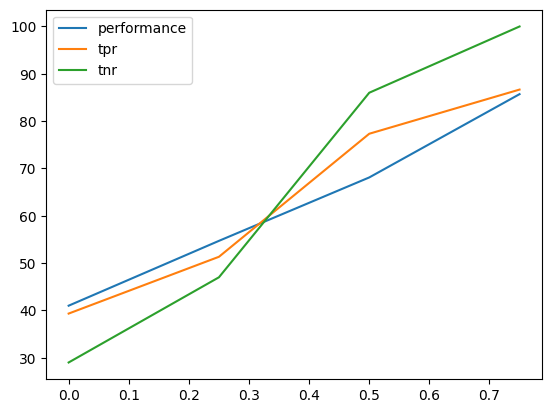

In [5]:
plot_df(final_perf_tpr_tnr, 'targeted_label_flip').plot()

<Axes: >

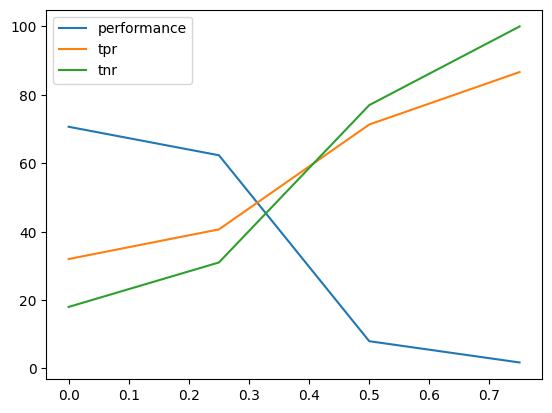

In [6]:
plot_df(final_perf_tpr_tnr, 'dba').plot()

# Adversarial contribution in ensemble model vs LIPC score

<Axes: xlabel='adv_contrib', ylabel='score'>

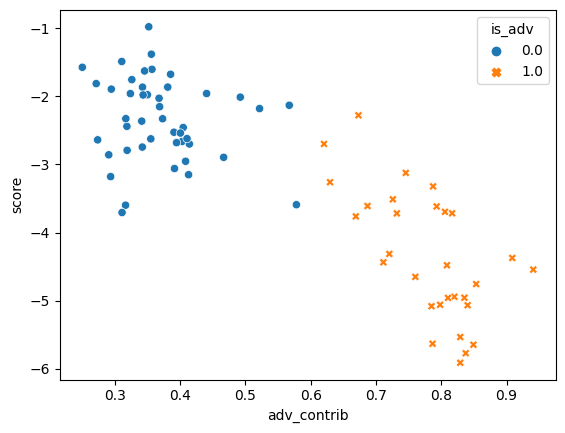

In [3]:
adv_contrib_vs_score_df = get_adv_contrib_vs_score()
sns.scatterplot(x='adv_contrib', y='score', style='is_adv', hue='is_adv', data=adv_contrib_vs_score_df)